In [1]:
### Import necessary libraries & packages ###
import os
import tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
import xgboost as xgb


import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV 

from sklearn.metrics import roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics
# Our custom functions #
#%run clf_functions.ipynb

from nltk import word_tokenize
from gensim.models import word2vec

Using TensorFlow backend.


from zipfile import ZipFile
ZipFile("glove.6B.zip").extractall("")

In [2]:
df = pd.read_csv('dataset_multi_valued.csv')
print(len(df))
df.head()

9070


,Brand,Sentiment,Clean_tweet
0,iPhone,0,g iphon hr tweet riseaustin dead need upgrad p...
1,iPad or iPhone App,4,know awesom ipadiphon app like appreci design ...
2,iPad,4,not wait ipad also sale sxsw
3,iPad or iPhone App,0,hope year' festiv crashi year' iphon app sxsw
4,Google,4,great stuff fri sxsw marissa mayer googl tim o...


In [3]:
#Store the column that will be the target, 'Sentiment', in the variable target
target = df['Sentiment']
data = df['Clean_tweet'].map(word_tokenize).values

In [4]:
total_vocabulary = set(word for tweet in data for word in tweet)


In [5]:
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 8278 unique tokens in the dataset.


In [6]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [7]:
glove['store']

array([ 0.37654 , -0.11085 ,  0.44753 ,  0.074111,  1.2254  , -0.47413 ,
       -1.7132  , -0.5622  ,  0.79129 ,  0.046365,  0.059305, -0.54642 ,
       -0.18154 , -0.44504 ,  0.71593 ,  0.66323 , -0.82844 ,  0.25531 ,
        0.22561 , -0.76825 ,  1.7314  , -0.35955 , -0.83919 ,  0.98962 ,
       -1.0577  , -0.89327 , -0.9075  ,  0.5392  ,  1.1759  , -1.0481  ,
        2.3297  , -0.24447 ,  0.6385  ,  0.06974 ,  0.38696 ,  0.32883 ,
        0.11177 ,  0.58524 ,  0.82529 ,  0.023072,  0.6235  , -0.036357,
       -0.28549 , -0.14505 ,  0.50543 ,  0.27194 , -0.10292 , -0.96804 ,
        0.28179 ,  0.50417 ], dtype=float32)

In [8]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [9]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])
knn = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('KNeighbors', KNeighborsClassifier())])
xgb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('XGBoost', xgb.XGBClassifier(random_state=30))])

In [10]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr),
          ('KNeighbors', knn),
          ('XGBoost', xgb)]

In [11]:
scores = [(name, cross_val_score(model, data, target, cv=3).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [12]:
scores

[('Random Forest', 0.6166492021472166),
 ('Support Vector Machine', 0.5926130189311305),
 ('Logistic Regression', 0.6079383171264927),
 ('KNeighbors', 0.586879491605942),
 ('XGBoost', 0.6138917193958006)]

In [13]:
scores_df = pd.DataFrame(scores, columns = ['Classifier_name', 'Classifier_score'])

In [14]:
scores_df

,Classifier_name,Classifier_score
0,Random Forest,0.616649
1,Support Vector Machine,0.592613
2,Logistic Regression,0.607938
3,KNeighbors,0.586879
4,XGBoost,0.613892


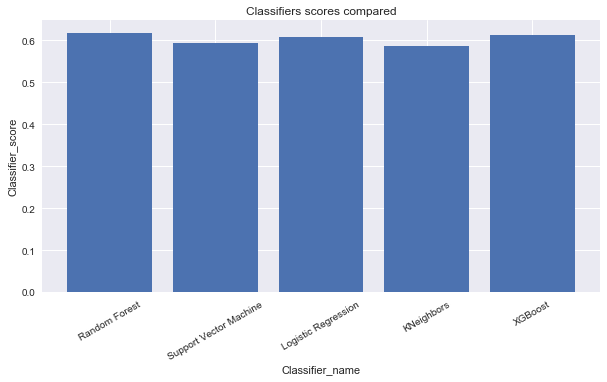

In [15]:
x_values=scores_df['Classifier_name']
y_values=scores_df['Classifier_score']
plt.figure(figsize=(10,5))
plt.bar(x_values, y_values, label="Classifiers")
plt.xlabel('Classifier_name')
plt.xticks( scores_df['Classifier_name'], rotation=30) 
plt.ylabel("Classifier_score")
plt.title('Classifiers scores compared')
plt.show()

In [16]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df['Clean_tweet'], df['Sentiment'], test_size = 0.20, random_state = 100)

'fit_on_texts' -  Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

'texts_to_sequences' -  Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. 

'pad_sequences' - This function transforms a list of num_samples sequences (lists of integers) into a matrix of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.

Sequences that are shorter than num_timesteps are padded with value at the end.

Sequences longer than num_timesteps are truncated so that they fit the desired length. The position where padding or truncation happens is determined by the arguments padding and truncating, respectively.

In [17]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(X_train.astype(str).values)
train_tweets = tokenizer.texts_to_sequences(X_train.astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(X_test.astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)

In [18]:
test_tweets

array([[  0,   0,   0, ..., 119, 701, 597],
       [  0,   0,   0, ...,   2,   1,  15],
       [  0,   0,   0, ..., 332,   1, 277],
       ...,
       [  0,   0,   0, ..., 340, 255,   1],
       [  0,   0,   0, ...,  11,   3,   1],
       [  0,   0,   0, ...,  15,   1,   4]], dtype=int32)

In [19]:
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(4, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 651,268
Trainable params: 651,268
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(y_train).values, epochs = 10, batch_size = 128, validation_split = 0.2)

Train on 5804 samples, validate on 1452 samples
Epoch 1/10
5804/5804 [==============================] - 4s 682us/step - loss: 0.9852 - acc: 0.5684 - val_loss: 0.8970 - val_acc: 0.6012
Epoch 2/10
5804/5804 [==============================] - 4s 605us/step - loss: 0.8781 - acc: 0.5939 - val_loss: 0.8367 - val_acc: 0.6129
Epoch 3/10
5804/5804 [==============================] - 4s 608us/step - loss: 0.7893 - acc: 0.6499 - val_loss: 0.7693 - val_acc: 0.6687
Epoch 4/10
5804/5804 [==============================] - 4s 618us/step - loss: 0.6840 - acc: 0.7178 - val_loss: 0.7472 - val_acc: 0.6811
Epoch 5/10
5804/5804 [==============================] - 4s 623us/step - loss: 0.6138 - acc: 0.7484 - val_loss: 0.7505 - val_acc: 0.6784
Epoch 6/10
5804/5804 [==============================] - 4s 626us/step - loss: 0.5655 - acc: 0.7788 - val_loss: 0.7994 - val_acc: 0.6577
Epoch 7/10
5804/5804 [==============================] - 4s 629us/step - loss: 0.5288 - acc: 0.7870 - val_loss: 0.7854 - val_acc: 0.6736


In [21]:
# Testing the model
score, accuracy = model.evaluate(test_tweets, pd.get_dummies(y_test).values, batch_size = 128)
print("Test accuracy: {0:.6f}".format(accuracy))


1814/1814 [==============================] - 0s 172us/step
Test accuracy: 0.643881


In [22]:
keras_row= {'Classifier_name': 'Keras model','Classifier_score': "{0:.6f}".format(accuracy)}
#append row to the dataframe
scores_df = scores_df.append(keras_row, ignore_index=True)

In [23]:
scores_df['Classifier_score'] = pd.to_numeric(scores_df['Classifier_score'], errors='ignore')

In [24]:
scores_df

,Classifier_name,Classifier_score
0,Random Forest,0.616649
1,Support Vector Machine,0.592613
2,Logistic Regression,0.607938
3,KNeighbors,0.586879
4,XGBoost,0.613892
5,Keras model,0.643881


In [25]:
y = max(scores_df['Classifier_score'])
y        

0.643881

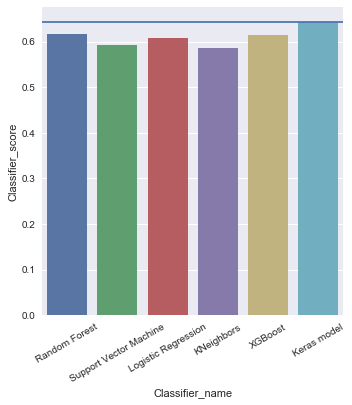

In [26]:
g = sns.catplot(x='Classifier_name', y='Classifier_score', kind = 'bar', data = scores_df)
g.set_xticklabels(rotation=30)
ax=plt.gca()  
ax.axhline(y= y)

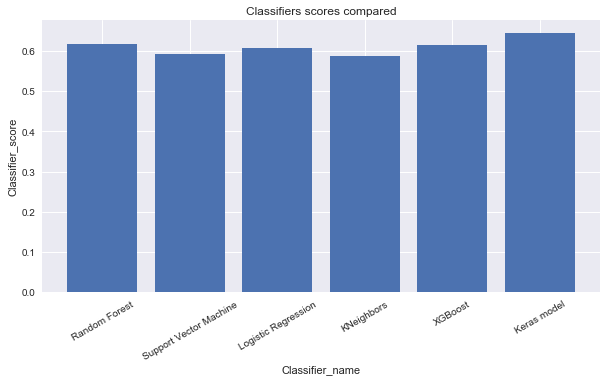

In [27]:
x_values=scores_df["Classifier_name"]
y_values=scores_df['Classifier_score']
plt.figure(figsize=(10,5))
plt.bar(x_values, y_values, label="Classifiers")
plt.xlabel('Classifier_name')
plt.xticks( scores_df['Classifier_name'], rotation=30) 
plt.ylabel("Classifier_score")
plt.title('Classifiers scores compared')
plt.show()